In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
## Working directory
image_path_gaussian_pyr  = 'Output/Gaussian/'
image_path_laplacian_pyr  = 'Output/Laplacian/'

In [3]:
##--------------------------------------------------------##
##   Find the Gaussian pyramid of the all input images    ##
##--------------------------------------------------------## 
def Gaussian_Pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyramid = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyramid.append(np.float32(lower))
    return gaussian_pyramid

In [4]:
##-------------------------------------------------------------------------##
##   Find the Laplacian pyramid of the background anf foreground images    ##
##-------------------------------------------------------------------------## 
def Laplacian_Pyramid(gaussian_pyramid):
    laplacian_top = gaussian_pyramid[-1]
    num_levels = len(gaussian_pyramid) - 1
    laplacian_pyramid = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

In [5]:
##--------------------------------------------------------##
##   Blend the two images with respect to the mask        ##
##--------------------------------------------------------##  
def Blending_Images(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for Laplacian_of_image_a,Laplacian_of_image_B,mask in zip(laplacian_B,laplacian_A,mask_pyr):
        ls = Laplacian_of_image_a * mask + Laplacian_of_image_B * (1.0 - mask)
        LS.append(ls)
    return LS

In [6]:
##--------------------------------------------------------------------------------##
##  Reconstruct the blended image with the size equivalent to the input images    ##
##--------------------------------------------------------------------------------##  
def Reconstructing_Blended_Image(Laplacian_Added):
    laplacian_top = Laplacian_Added[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(Laplacian_Added) - 1
    for i in range(num_levels):
        size = (Laplacian_Added[i + 1].shape[1], Laplacian_Added[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(Laplacian_Added[i+1], laplacian_expanded,dtype=cv2.CV_32F)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

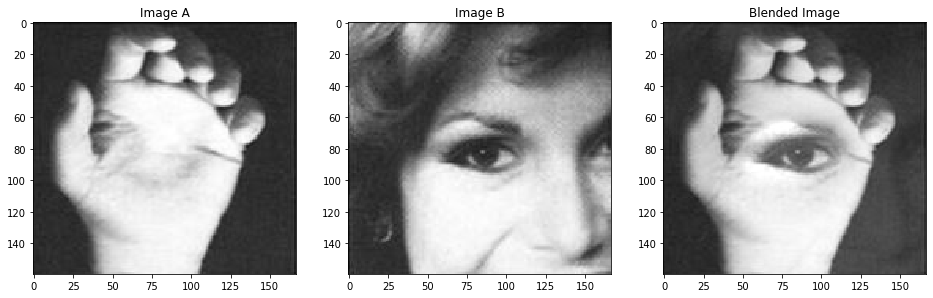

In [7]:
##----------------------------------------------------------------------##
##  Main function to accept input inages and call all the operations    ##
##----------------------------------------------------------------------## 
if __name__ == '__main__':
     # Accepting background and foreground images
    image_1 = cv2.imread('A.jpg')
    image_1 = cv2.resize(image_1, (167, 160))
    image_2 = cv2.imread('B.jpg')
    image_2 = cv2.resize(image_2, (167, 160))
 
    # Inserting mask image
    mask_image = cv2.imread('Mask.jpg').astype('float32')/255
    mask_image = cv2.resize(mask_image, (167, 160))
    mask_image_complement = cv2.imread('Mask.jpg')
    mask_image_complement = cv2.resize(mask_image_complement, (167, 160))
    mask_image_complement=cv2.bitwise_not(mask_image_complement)
  
     
    # x=np.multiply(mask_image_inv,(1.0 - mask_image))
    cv2.imwrite('Complement_of_Mask.jpg',mask_image_complement)
    #number of levels that the Gaussian and Laplacian pyramid 
    pyramid_level =8
    
    # For image-1, Constructing Gaussian Pyramid
    gaussian_pyr_1 = Gaussian_Pyramid(image_1, pyramid_level)
    # For image-1, Constructing Laplacian
    laplacian_pyr_1 = Laplacian_Pyramid(gaussian_pyr_1)
    # For image-2, Constructing Laplacian
    gaussian_pyr_2 = Gaussian_Pyramid(image_2, pyramid_level)
    #For image-2, Constructing Laplacian
    laplacian_pyr_2 = Laplacian_Pyramid(gaussian_pyr_2)
    #Storing the downsampled images in Output folder
    for i in range(pyramid_level):
        cv2.imwrite(image_path_gaussian_pyr + 'Gaussian_Pyr_Img_1_Lvl_{}.jpg'.format(i), gaussian_pyr_1[i])
        cv2.imwrite(image_path_laplacian_pyr + 'Laplacian_Pyr_Img_1_Lvl_{}.jpg'.format(i), laplacian_pyr_1[i])
        cv2.imwrite(image_path_gaussian_pyr + 'Gaussian_Pyr_Img_2_Lvl_{}.jpg'.format(i), gaussian_pyr_2[i])
        cv2.imwrite(image_path_laplacian_pyr + 'Laplacian_Pyr_Img_2_Lvl_{}.jpg'.format(i), laplacian_pyr_2[i])
    
    # Calculate the Gaussian pyramid for the mask image and complement mask image.
    mask_pyr_final = Gaussian_Pyramid(mask_image, pyramid_level)
    mask_pyr_final_compl = Gaussian_Pyramid(mask_image_complement, pyramid_level)
    mask_pyr_final.reverse()
    
    # Blend the images
    Laplacian_Added = Blending_Images(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
    
    # Reconstruct the images
    final  = Reconstructing_Blended_Image(Laplacian_Added)
    
    # Save the final image to the working directory
    cv2.imwrite('Blended.jpg',final[pyramid_level])
    blended_img = cv2.imread('Blended.jpg')
    figure, ax = plt.subplots(1, 3, figsize=(16,8))
    ax[0].imshow(image_1, cmap='gray')
    ax[0].set_title("Image A")
    ax[1].imshow(image_2, cmap='gray')
    ax[1].set_title("Image B")
    ax[2].imshow(blended_img, cmap='gray')
    ax[2].set_title("Blended Image")
#     print("\n----------Program executed successfully!!")
#     print("\n----------Blended Image Reconstructed")